# Tensor Networks Assignment 2025/26
### Mar López

In this assignement, we are going to study the real-time evolution of the transverse-field Ising model in a one-dimensional spin-1/2 chain with open boundary conditions. The Hamiltonian that describes this model is
$$
H_{Ising}(g) = \sum_{i=1}^{N-1}X_iX_{i+1} + g \sum_i^N Z_i \quad .
$$

The goal is to compute the expectation value of the local operator $Z_{i=N/2}(t)$ using two different tensor-network contraction strategies: 

- Standard real-time evolution with MPS (TEBD).
- Spatial contraction of the corresponding tensor network.

First, we can import the modules we are going to use.

In [62]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [63]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

tenpy.tools.misc.setup_logging(to_stdout="INFO")

## Part I: Expectation value with TEBD

In this section, we compute the expectation value of the local operator $Z_{i=N/2}(t)$ up to time $T=5$ using TEBD (Time Evolving Block Decimation). TEBD is an algorithm for simulating the time evolution of one-dimensional quantum many-body systems represented as Matrix Product States (MPS).

To do so, we will use and adapt the TEBD example provided by TenPy: [A first TEBD Example](https://tenpy.readthedocs.io/en/v1.0.4/notebooks/00_tebd.html).

### Model Setup and Initialization

First, we set up the initial parameters for the TEBD simulation. We define a chain of length $L = 50$ spins and create a TFIChain model with coupling strength $J = 1.0$ and transverse field $g = 0.7$.

In [73]:
N = 50
g = 0.7
T = 4.0
dt = 0.1
chi_max = 200

In [74]:
model_params = {
    'J': 1. ,
    'g': g ,
    'L': N ,
    'bc_MPS': 'finite',
}

M = TFIChain(model_params)

INFO    : TFIChain: reading 'bc_MPS'='finite'
INFO    : TFIChain: reading 'L'=50
INFO    : TFIChain: reading 'J'=1.0
INFO    : TFIChain: reading 'g'=0.7


With the chosen model, we build the initial state `psi` as a product-state MPS on the lattice `M.lat`.
The list `[['up']]` means every site starts in the local state $\ket{\uparrow}$, so the initial state is $\ket{\uparrow\uparrow\uparrow...\uparrow}$.

In [75]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

Then, we set the TEBD parameters (time step, Trotter order) and the truncation settings that control the maximum bond dimension and discarded singular values. 

We also create the TEBD engine that evolves `psi` with the model `M` using the previous parameters.

In [76]:
tebd_params = {
    'N_steps': 1,
    'dt': dt,
    'order': 4,
    'trunc_params': {'chi_max': chi_max, 'svd_min': 1.e-12}
}

eng = tebd.TEBDEngine(psi, M, tebd_params)

INFO    : TEBDEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')


### Measurement and data collection

To analyze the real-time dynamics of the system, we need to extract physical observables from the evolving MPS state. We define a `measurement` function that systematically records key quantities at each time step. The observables we measure are:

- Entanglement entropy: reveals how quantum correlations grow as the system evolves far from equilibrium.
- Local magnetization: ($\langle \sigma_x \rangle$, $\langle \sigma_z \rangle$) provides insight into the expectation values of individual operators.
- Correlations: ($\langle \sigma_x^i \sigma_x^j \rangle$) characterize how information spreads across the chain.
- Truncation error: monitors the numerical accuracy of our MPS approximation throughout the evolution.

The `measurement` function is called at each time step to build a comprehensive dataset that we later analyze and visualize.

In [68]:
def measurement(eng, data):
    """Collect observables from the current TEBD state.
    Args:
        eng: TEBD engine with the current MPS state.
        data: dict of lists or None (initialized if None).
    Returns:
        data: dict with time, entropy, magnetization, correlations, and truncation error.
    """
    keys = ['t', 'entropy', 'Sx', 'Sz', 'corr_XX', 'corr_ZZ', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['corr_XX'].append(eng.psi.correlation_function('Sigmax', 'Sigmax'))
    data['corr_ZZ'].append(eng.psi.correlation_function('Sigmaz', 'Sigmaz'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

In [69]:
data = measurement(eng, None)
while eng.evolved_time < T:
    eng.run()
    measurement(eng, data)

INFO    : TEBDEngine: reading 'dt'=0.1
INFO    : TEBDEngine: reading 'N_steps'=1
INFO    : TEBDEngine: reading 'order'=4
INFO    : Calculate U for {'order': 4, 'delta_t': 0.1, 'type_evo': 'real', 'E_offset': None, 'tau': 0.1}
INFO    : trunc_params: reading 'chi_max'=200
INFO    : trunc_params: reading 'svd_min'=1e-12
INFO    : --> time=0.100 + 0.000j, max(chi)=5, max(S)=0.05555, avg DeltaS=5.5551e-02, since last update: 2.9s
INFO    : --> time=0.200 + 0.000j, max(chi)=6, max(S)=0.16306, avg DeltaS=1.0751e-01, since last update: 1.4s
INFO    : --> time=0.300 + 0.000j, max(chi)=8, max(S)=0.28501, avg DeltaS=1.2194e-01, since last update: 1.9s
INFO    : --> time=0.400 + 0.000j, max(chi)=9, max(S)=0.40094, avg DeltaS=1.1589e-01, since last update: 2.4s
INFO    : --> time=0.500 + 0.000j, max(chi)=10, max(S)=0.49966, avg DeltaS=9.8619e-02, since last update: 2.1s
INFO    : --> time=0.600 + 0.000j, max(chi)=12, max(S)=0.57712, avg DeltaS=7.7300e-02, since last update: 2.0s
INFO    : --> time

### Results: Observable Dynamics During Time Evolution

To analyze the TEBD simulation results, we visualize four key observables that characterize the system's evolution from the initial product state $|\uparrow\uparrow...\uparrow\rangle$:

- Entanglement Entropy (top-left): Shows the von Neumann entropy $S = -\text{Tr}(\rho\log\rho)$ at the center bond (site $N/2$). The increase of entropy indicates the growth of quantum correlations as the system evolves from the initially separable product state.

- Total Magnetization (top-right): Tracks the total magnetization $\sum_i\langle\sigma_x^i\rangle$ (blue) and $\sum_i\langle\sigma_z^i\rangle$ (orange) across all sites. The decay from the initial values reveals how the system moves away from the $\ket{\uparrow}$ product state as quantum dynamics mix the spin configurations. The Z-magnetization starts at its maximum value (all spins up) and oscillates while decreasing.

- Spatial Correlations (bottom-left): Displays two-point correlation functions $\langle X_i X_j\rangle$ as a function of the site. Different curves (color-coded by time) show how correlations spread spatially.

- Truncation Error (bottom-right): Monitors the discarded weight from SVD truncation at each time step. The low values (typically $<10^{-10}$) confirm that our maximum bond dimension $\chi_{\max}=200$ provides highly accurate results throughout the evolution. Sudden increases in truncation error indicate moments when the quantum state becomes more entangled.

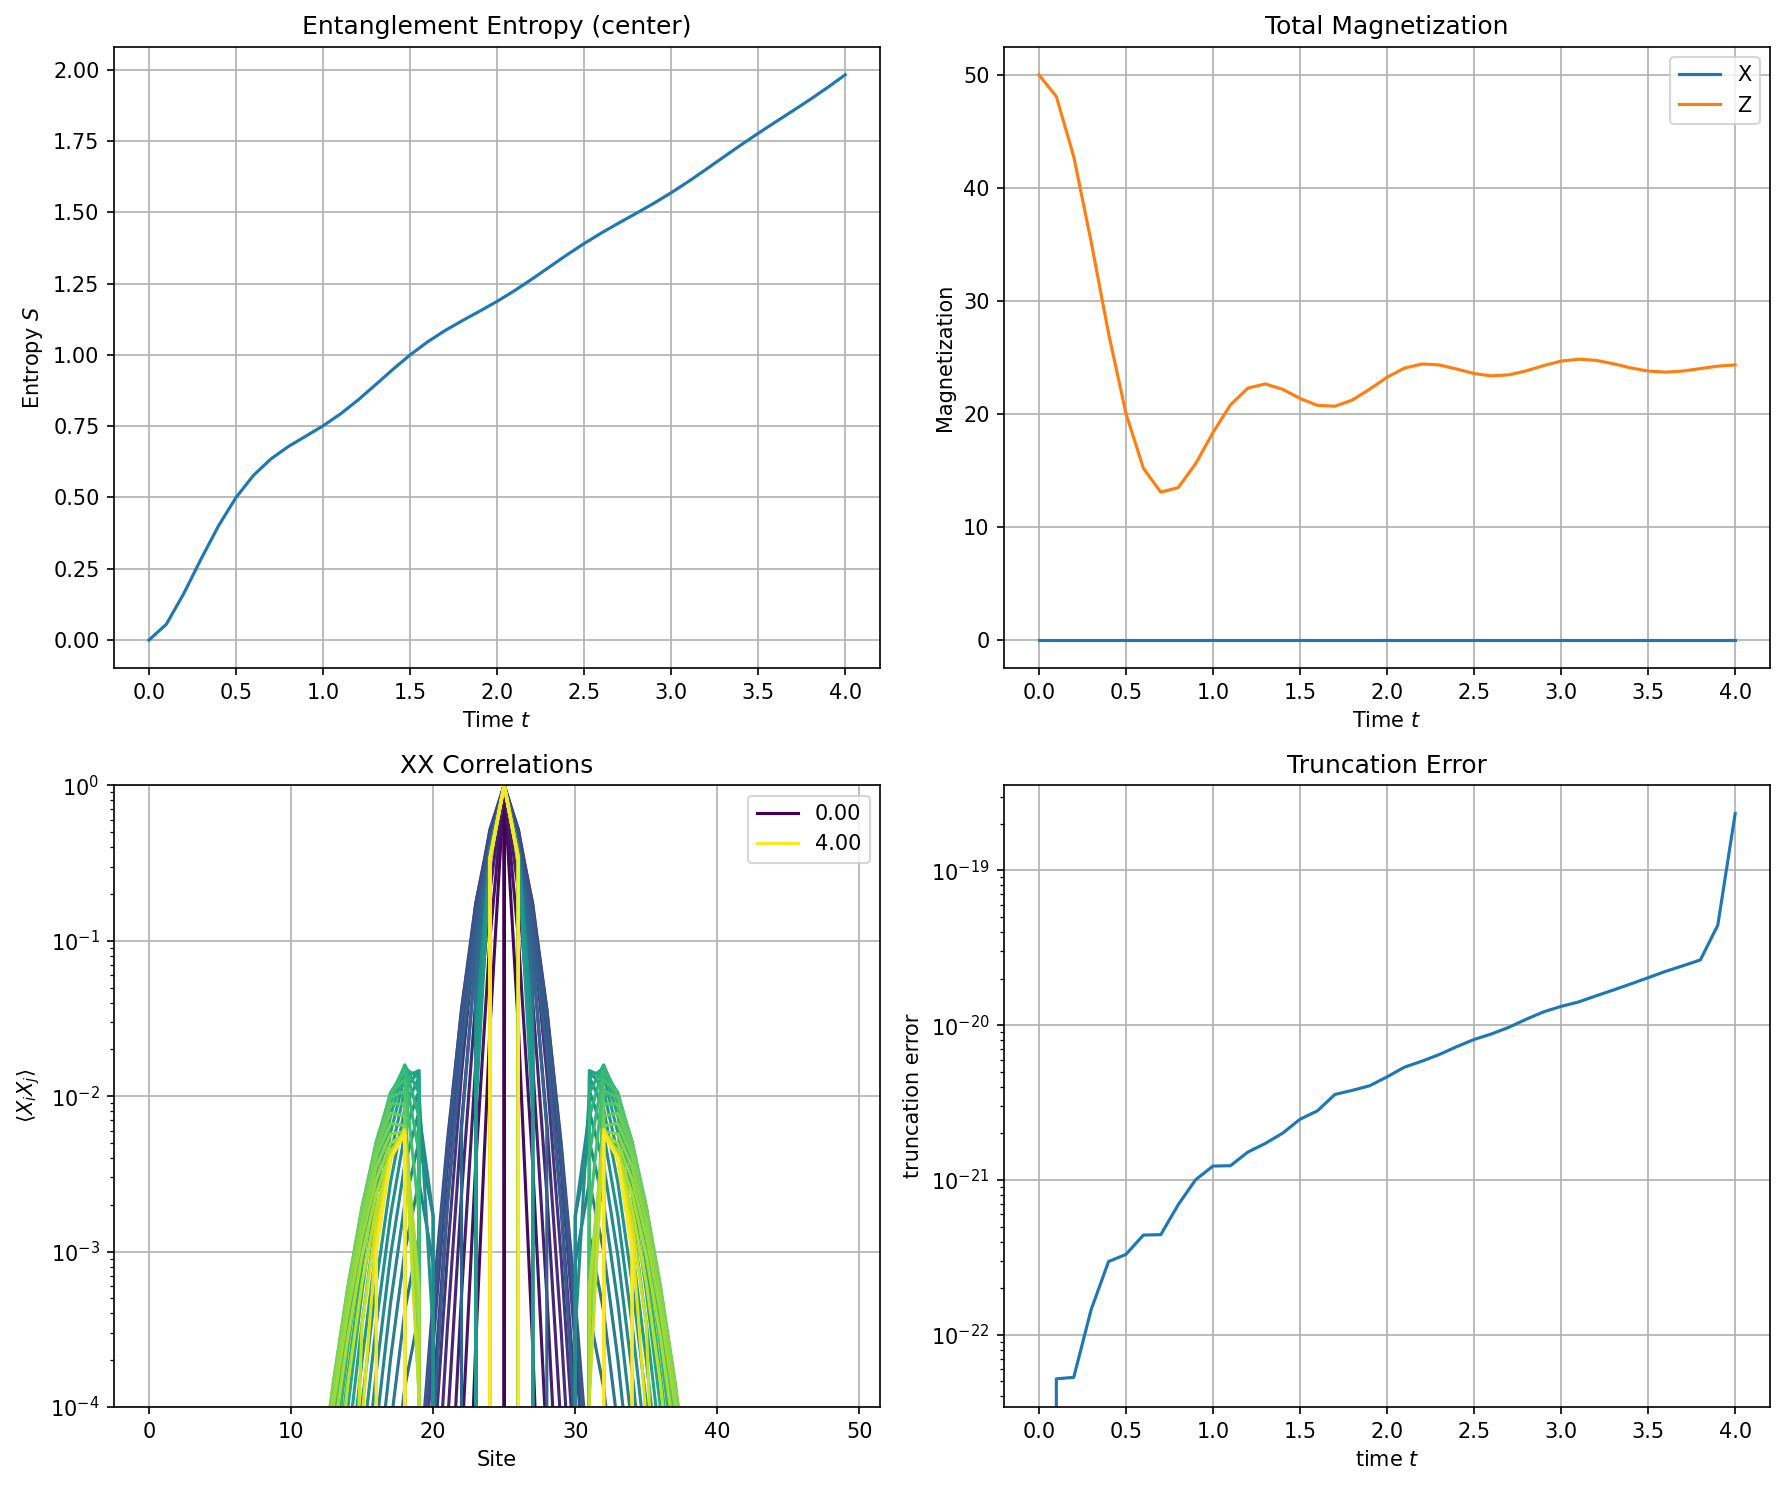

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Entanglement entropy at center
axes[0, 0].plot(data['t'], np.array(data['entropy'])[:, N//2])
axes[0, 0].set_xlabel('Time $t$')
axes[0, 0].set_ylabel('Entropy $S$')
axes[0, 0].set_title('Entanglement Entropy (center)')
axes[0, 0].grid(True)

# Plot 2: Magnetization
axes[0, 1].plot(data['t'], np.sum(data['Sx'], axis=1), label='X')
axes[0, 1].plot(data['t'], np.sum(data['Sz'], axis=1), label='Z')
axes[0, 1].set_xlabel('Time $t$')
axes[0, 1].set_ylabel('Magnetization')
axes[0, 1].set_title('Total Magnetization')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True)

# Plot 3: Correlations
corrs = np.array(data['corr_XX'])
tmax = data['t'][-1]
x = np.arange(N)
cmap = matplotlib.cm.viridis
for i, t in list(enumerate(data['t'])):
    if i == 0 or i == len(data['t']) - 1:
        label = '{t:.2f}'.format(t=t)
    else:
        label = None
    axes[1, 0].plot(x, corrs[i, N//2, :], color=cmap(t/tmax), label=label)
axes[1, 0].set_xlabel(r'Site')
axes[1, 0].set_ylabel(r'$\langle X_i X_j \rangle$')
axes[1, 0].set_title('XX Correlations')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylim(1.e-4, 1.)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Truncation error
axes[1, 1].plot(data['t'], data['trunc_err'])
axes[1, 1].set_yscale('log')
#plt.ylim(1.e-15, 1.)
axes[1, 1].set_xlabel('time $t$')
axes[1, 1].set_ylabel('truncation error')
axes[1, 1].set_title('Truncation Error')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Extract Z_{N/2}(t) from the Sz expectation values
z_center = np.array([sz[N//2] for sz in data['Sz']])

# Plot Z_{N/2}(t)
plt.figure(figsize=(10, 6))
plt.plot(data['t'], z_center, 'o-', linewidth=2, markersize=4)
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('$\langle Z_{N/2}(t) \\rangle$', fontsize=12)
plt.title('Local Magnetization at Center Site', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part II: Expectation value via transverse contraction